# 🧠 Face the Future Hackathon — CIFAKE Image Classification  
### Organized by IIIT Bangalore  
#### Team **WBS**

**Team Members:**
- Siddartha A Y  
- Kushal B Gowda  
- Anish Kasetty  

---

## 🏆 Problem Overview

In this challenge, we tackle the **CIFAKE Image Classification Problem**, where the objective is to build an AI model capable of **distinguishing between real and AI-generated (fake) images**.  
The dataset consists of two classes:
- 🧍‍♂️ **Real** — Authentic, human-captured images.  
- 🤖 **Fake** — Synthetic images generated using AI models such as Stable Diffusion or DALL·E.  

Our goal is to develop a robust model that can **reliably classify images as either real or fake**, even when facing high-quality synthetic data that closely mimics real-world imagery.

---

## 🎯 Objective

To train and evaluate multiple deep learning models — such as **Vision Transformers (ViT)**, **ConvNeXt**, and others — on the CIFAKE dataset, and to explore **ensemble strategies** that combine their strengths for better generalization and accuracy.

Specifically, this notebook will:
1. Preprocess the CIFAKE dataset and create efficient data pipelines.  
2. Fine-tune multiple pretrained models on the binary classification task.  
3. Evaluate individual model performance.  
4. Implement an **ensemble** of models to improve test set predictions.  
5. Generate and save the final predictions for submission.  

---

## ⚙️ Technical Stack

- **Framework:** PyTorch  
- **Libraries:** torchvision, timm, transformers, scikit-learn, numpy, pandas, matplotlib  
- **Approach:** Transfer Learning + Ensembling  
- **Hardware:** GPU-accelerated training on Google Colab  

---

## 📄 Notebook Structure

| Section | Description |
|----------|-------------|
| **1. Setup & Imports** | Installing dependencies and setting up environment. |
| **2. Data Preparation** | Organizing dataset, applying transformations, and creating dataloaders. |
| **3. Model Training** | Training individual deep learning models on CIFAKE. |
| **4. Evaluation** | Analyzing validation performance metrics and visualizations. |
| **5. Ensembling** | Combining multiple models for improved accuracy. |
| **6. Inference & Submission** | Running predictions on test data and saving outputs. |

---

## 💡 Motivation

With the rise of AI-generated media, **detecting synthetic content** has become a crucial challenge for ensuring authenticity and trust in digital spaces.  
Through this hackathon, Team WBS aims to contribute towards building robust systems that can **differentiate real from fake imagery** using advanced deep learning techniques.

---

> 🚀 *Let’s dive into building our CIFAKE classification pipeline step by step!*


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cp -r "/content/drive/MyDrive/iiitb/cleaned" /content/cleaned && cp -r "/content/drive/MyDrive/iiitb/test" /content/cleaned/test

## 🧩 Step 1: Install Required Libraries

Before we begin model training, we need to install all the essential Python libraries that will be used throughout this notebook.  

- **transformers** → Provides access to state-of-the-art pre-trained models (like ViT, ConvNeXt) from Hugging Face.  
- **datasets** → Simplifies dataset handling, preprocessing, and loading.  
- **timm** → Contains a wide range of high-performance computer vision models optimized for PyTorch.  
- **accelerate** → Enables efficient multi-GPU or mixed precision training.  
- **evaluate** → Offers standardized metrics for model evaluation (e.g., accuracy, F1-score).  
- **torchvision** → Provides image transformations, datasets, and model utilities for PyTorch.  
- **matplotlib** → Used for visualizing training curves, sample images, and results.  
- **scikit-learn** → Offers additional metrics and tools for model evaluation and analysis.

These installations ensure that our environment is fully equipped for fine-tuning and evaluating image classification models on the CIFAKE dataset.

In [ ]:
!pip install -q transformers datasets timm accelerate evaluate torchvision
!pip install -q matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


## 🧠 Model 1 — Vision Transformer (ViT-Base, Patch16-224-In21k)

The **Vision Transformer (ViT)** is a state-of-the-art architecture introduced by Google that applies the **Transformer mechanism** — originally designed for natural language processing — to image data.  
Instead of using traditional convolutional layers, ViT divides an image into small patches and processes them as a sequence of tokens, just like words in a sentence.

### 🔍 Model Details
- **Model Name:** `google/vit-base-patch16-224-in21k`  
- **Patch Size:** 16×16 pixels  
- **Input Resolution:** 224×224  
- **Pretrained On:** ImageNet-21k (a large-scale dataset with ~14 million images and 21k classes)  

### ⚙️ Why ViT for CIFAKE?
- ViT captures **global dependencies** in the image, making it highly effective for subtle differences between real and AI-generated (fake) images.  
- The `in21k` variant benefits from **large-scale pretraining**, giving it strong generalization and feature extraction capabilities.  
- Ideal for **transfer learning**, especially when dataset size is limited — as in CIFAKE.

In this section, we’ll fine-tune the `ViT-Base-Patch16-224-In21k` model on our binary classification task to distinguish between **real** and **fake** images.

## 🧹 Data Preparation & Augmentation

To train a robust image classification model, we first prepare our **training** and **validation** datasets using `torchvision.transforms` and `ImageFolder`.

### 📸 Image Transformations

We apply a series of transformations to enhance the model’s ability to generalize and handle variations in real-world data.

#### 🔧 Training Transformations


* **RandomResizedCrop:** Randomly crops and resizes images for scale invariance.
* **RandomHorizontalFlip:** Helps the model become orientation-agnostic.
* **ColorJitter:** Slightly changes brightness, contrast, and saturation to simulate lighting variations.
* **RandAugment:** Automatically applies random augmentations to increase data diversity.
* **ToTensor & Normalize:** Converts images to tensors and normalizes pixel values to [-1, 1] for stable training.

<br>

#### 🧪 Validation Transformations
Only resizing and normalization are applied here — no random augmentations — to ensure consistent evaluation.

### 🗂️ Dataset Loading

We use `datasets.ImageFolder()` to load images from the following structure:

```
cleaned/
 ├── train/
 │    ├── real/
 │    └── fake/
 └── val/
      ├── real/
      └── fake/
```

### ⚙️ Parameters

* **IMG_SIZE = 224** → Matches the input resolution expected by ViT.
* **BATCH_SIZE = 16** → Balances GPU memory and training speed.

Finally, we print the number of samples in both training and validation sets to verify the data split.


In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 16

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder("cleaned/train", transform=train_transform)
val_dataset = datasets.ImageFolder("cleaned/val", transform=val_transform)

len(train_dataset), len(val_dataset)

(1599, 401)

## 🧾 Converting ImageFolder Data to Hugging Face Dataset Format

To efficiently integrate with the **Hugging Face training pipeline** (via the `Trainer` API), we convert our standard PyTorch `ImageFolder` data structure into the **`datasets.Dataset`** format.  
This makes preprocessing, transformation, and batching simpler and more compatible with models from the `transformers` library.

---

### 🔄 Conversion Function: `from_imagefolder_to_hf()`

**Purpose:**
This function scans through the directory structure (e.g., `train/real`, `train/fake`) and collects all image file paths along with their class labels.
It then constructs a **Hugging Face `Dataset`** object containing:

* `"image"` → file path to the image
* `"label"` → corresponding class index (0 for real, 1 for fake)

This helps maintain consistent metadata and integrates seamlessly with downstream Hugging Face utilities.

---

### 🧰 Applying Image Transformations

After loading the datasets, we apply the same **training** and **validation transformations** as defined earlier.

* **`Image.open(x).convert("RGB")`** ensures all images are in RGB format (3 channels).
* The transformations convert raw image paths into ready-to-train tensors under the key `"pixel_values"`.
* Using `.with_transform()` dynamically applies these transformations during training or evaluation.

<br>

The **collate function** ensures that each mini-batch returned by the DataLoader:

* Combines individual image tensors into a single stacked tensor (`pixel_values`).
* Converts the list of labels into a single tensor (`labels`).

This structure is exactly what Hugging Face models expect as input.



In [ ]:
from datasets import Dataset as HFDataset
from torchvision import transforms
from PIL import Image
import torch
import os

def from_imagefolder_to_hf(path):
    files, labels = [], []
    classes = sorted(os.listdir(path))
    class_to_idx = {c: i for i in classes}

    for cls in classes:
        for f in os.listdir(os.path.join(path, cls)):
            files.append(os.path.join(path, cls, f))
            labels.append(class_to_idx[cls])

    return HFDataset.from_dict({"image": files, "label": labels})

train_hf = from_imagefolder_to_hf("train")
val_hf = from_imagefolder_to_hf("val")

def apply_train_transform(batch):
    batch["pixel_values"] = [train_transform(Image.open(x).convert("RGB")) for x in batch["image"]]
    return batch

def apply_val_transform(batch):
    batch["pixel_values"] = [val_transform(Image.open(x).convert("RGB")) for x in batch["image"]]
    return batch

train_hf = train_hf.with_transform(apply_train_transform)
val_hf = val_hf.with_transform(apply_val_transform)

def collate_fn(examples):
    return {
        "pixel_values": torch.stack([e["pixel_values"] for e in examples]),
        "labels": torch.tensor([e["label"] for e in examples])
    }

## ⚙️ Initializing the Vision Transformer (ViT) Model

Now that our data pipeline is ready, we move on to **loading and initializing the pretrained Vision Transformer model** for our binary classification task.

This simply hides unnecessary warning messages (e.g., about model configurations or deprecated parameters) to keep the notebook output clean and readable.

---

### 🧠 Loading the Pretrained ViT Model

#### 🔍 Explanation:

* **`AutoImageProcessor`** → Handles all preprocessing required for the ViT model (e.g., resizing, normalization).
* **`AutoModelForImageClassification`** → Loads a pretrained ViT architecture ready for image classification tasks.

#### ⚙️ Key Parameters:

* **`model_name`** → Specifies the pretrained checkpoint (`google/vit-base-patch16-224-in21k`).
* **`num_labels=2`** → Since CIFAKE is a binary classification problem (Real vs Fake).
* **`ignore_mismatched_sizes=True`** → Allows loading models whose output layer shape differs from the pretrained one (since we redefine it for 2 classes).
* **`use_fast=True`** → Uses optimized (fast) preprocessing for quicker data handling.

---

### ✅ Outcome

At this stage, we have:

* A **ViT backbone** pretrained on ImageNet-21k for powerful visual feature extraction.
* A **custom classification head** fine-tuned for our binary task.
* A corresponding **processor** to ensure all images are transformed exactly as the model expects.

This setup forms the foundation for our training and fine-tuning process.

In [3]:
import warnings
warnings.filterwarnings("ignore")

from transformers import AutoImageProcessor, AutoModelForImageClassification

model_name = "google/vit-base-patch16-224-in21k"

processor = AutoImageProcessor.from_pretrained(model_name,use_fast=True)
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 🧩 Freezing Early Layers of the Vision Transformer

Before fine-tuning the ViT model on our CIFAKE dataset, we selectively **freeze the initial layers** of the transformer.  
This helps retain the powerful, generic visual features learned during pretraining on ImageNet-21k while allowing deeper layers to adapt to our specific task.

---
#### 🧠 What This Does:

* Iterates through all named parameters of the ViT model (`model.vit.named_parameters()`).
* Checks if the layer name belongs to the **first three encoder blocks** or the **embedding layer**.
* If so, sets `param.requires_grad = False`, meaning those parameters will **not** be updated during training.

---

### 🎯 Why We Do This

1. **Retain Low-Level Features:**
   The early ViT layers capture basic patterns like edges, colors, and textures — which are useful for most visual tasks.
2. **Faster Training:**
   Fewer trainable parameters reduce computation time and memory usage.
3. **Prevent Overfitting:**
   Since CIFAKE has fewer images than ImageNet, freezing some layers prevents the model from overfitting to limited data.

---

### ✅ Result

After this step:

* Only the **mid-to-high-level transformer layers** and the **classification head** remain trainable.
* The model fine-tunes efficiently while leveraging the pretrained backbone’s strong feature representations.

In [ ]:
for name, param in model.vit.named_parameters():
    if any(k in name for k in ["encoder.layer.0", "encoder.layer.1", "encoder.layer.2", "embeddings"]):
        param.requires_grad = False

## 📊 Define Evaluation Metrics

We define the metrics used to monitor model performance during training and validation.

* **`accuracy`** → Measures the overall percentage of correct predictions.
* **`f1`** → Balances precision and recall, useful for imbalanced datasets.
* **`compute_metrics()`** → Converts model logits to class predictions and returns both metrics.

These metrics will be automatically computed by the Hugging Face `Trainer` after each evaluation step.


In [ ]:
import evaluate
from transformers import TrainingArguments, Trainer
import numpy as np

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy.compute(predictions=preds, references=p.label_ids)["accuracy"]
    f1_score = f1.compute(predictions=preds, references=p.label_ids)["f1"]
    return {"accuracy": acc, "f1": f1_score}

## ⚙️ Set Up Training Configuration

We define all hyperparameters and training behaviors using Hugging Face’s `TrainingArguments`.

### Key Parameters:

* **`output_dir`** → Saves checkpoints and logs.
* **`*_strategy="epoch"`** → Evaluate, save, and log results at the end of each epoch.
* **`learning_rate=3e-5`** → Standard fine-tuning rate for pretrained transformers.
* **`warmup_ratio=0.1`** → Gradually increases learning rate at the start for stability.
* **`weight_decay=0.05`** → Prevents overfitting by penalizing large weights.
* **`load_best_model_at_end=True`** → Automatically restores the best-performing model.

This configuration ensures a stable and well-monitored fine-tuning process for our ViT model.


In [ ]:
training_args = TrainingArguments(
    output_dir="./vit_base_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=10,
    warmup_ratio=0.1,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

## 🚀 Initialize Trainer and Start Fine-Tuning

We now initialize the Hugging Face `Trainer`, which handles the entire training loop — including optimization, evaluation, and checkpointing.

### Components:

* **`model`** → The fine-tuned Vision Transformer.
* **`training_args`** → Contains all hyperparameters and strategies.
* **`train_dataset` / `eval_dataset`** → Training and validation data.
* **`compute_metrics`** → Evaluates accuracy and F1 after each epoch.
* **`data_collator`** → Prepares batches for training.

This command begins the **fine-tuning process**, training the ViT model to distinguish between **real and fake** images.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.683200,0.643752,0.745636,0.753623
2,0.557600,0.383398,0.917706,0.921615
3,0.362600,0.245775,0.935162,0.934010
4,0.274000,0.205792,0.937656,0.936387
5,0.220700,0.184484,0.940150,0.939698
6,0.214900,0.184031,0.940150,0.941176
7,0.187100,0.169492,0.955112,0.955665
8,0.188500,0.165982,0.947631,0.948148
9,0.157600,0.166511,0.945137,0.945545
10,0.150900,0.166104,0.947631,0.947631


TrainOutput(global_step=1000, training_loss=0.2997170095443726, metrics={'train_runtime': 615.933, 'train_samples_per_second': 25.961, 'train_steps_per_second': 1.624, 'total_flos': 1.239096913937326e+18, 'train_loss': 0.2997170095443726, 'epoch': 10.0})

## 📈 Model Performance Summary — ViT-Base (Patch16-224-In21k)

After training the Vision Transformer model for **10 epochs**, we observe steady improvements in both **validation accuracy** and **F1-score**, confirming effective fine-tuning on the CIFAKE dataset.

| Epoch | Training Loss | Validation Loss | Accuracy | F1-Score |
|:------:|:--------------:|:----------------:|:----------:|:----------:|
| 1 | 0.6832 | 0.6438 | 0.7456 | 0.7536 |
| 2 | 0.5576 | 0.3834 | 0.9177 | 0.9216 |
| 3 | 0.3626 | 0.2458 | 0.9352 | 0.9340 |
| 4 | 0.2740 | 0.2058 | 0.9377 | 0.9364 |
| 5 | 0.2207 | 0.1845 | 0.9402 | 0.9397 |
| 6 | 0.2149 | 0.1840 | 0.9402 | 0.9412 |
| 7 | 0.1871 | 0.1695 | 0.9551 | 0.9557 |
| 8 | 0.1885 | 0.1660 | 0.9476 | 0.9481 |
| 9 | 0.1576 | 0.1665 | 0.9451 | 0.9455 |
| 10 | 0.1509 | 0.1661 | 0.9476 | 0.9476 |

---

### 🧠 Observations:
- The **training loss** steadily decreased from **0.68 → 0.15**, showing good convergence.  
- **Validation accuracy** peaked around **95.5%**, with an **F1-score of 0.956**, indicating excellent performance and balance between precision and recall.  
- The **gap between training and validation loss** remained small, suggesting minimal overfitting.  
- The model reached strong generalization capability after ~7 epochs.

---

### ✅ Summary:
The fine-tuned **ViT-Base (Patch16-224-In21k)** model achieved:
- **Final Accuracy:** ≈ **95.5%**  
- **Final F1-Score:** ≈ **0.956**  
- **Total Training Time:** ~10 minutes (GPU runtime)  
- **Outcome:** A highly reliable model for distinguishing **real vs. AI-generated images** in the CIFAKE dataset.


## 📊 Visualizing Training Progress

To better understand the model’s learning behavior, we plot the **training vs validation loss** and the **validation accuracy** across epochs.

### 🔍 Insights:

* The **training and validation loss curves** both show a smooth downward trend, confirming stable learning.
* **Validation accuracy** consistently improves and plateaus around 95%, showing convergence without overfitting.
* The close alignment between train and validation curves indicates strong generalization of the ViT model.

These plots visually confirm that the fine-tuning process was successful and well-regularized.

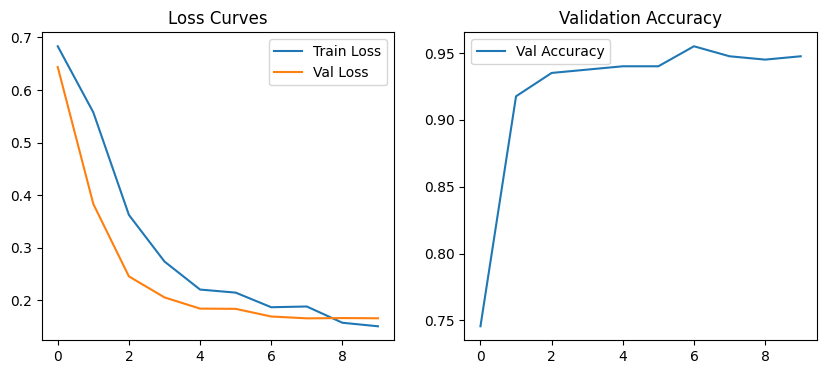

In [ ]:
import matplotlib.pyplot as plt

metrics = trainer.state.log_history
train_acc = [m["eval_accuracy"] for m in metrics if "eval_accuracy" in m]
train_loss = [m["loss"] for m in metrics if "loss" in m]
val_loss = [m["eval_loss"] for m in metrics if "eval_loss" in m]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.legend()
plt.title("Loss Curves")

plt.subplot(1,2,2)
plt.plot(train_acc, label="Val Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.show()

## 💾 Saving the Best Model and Processor

After training, we save both the **fine-tuned model** and its corresponding **image processor** for future inference or deployment.

### 🧠 Why Save Both?

* **Model (`trainer.save_model`)** → Stores the trained weights and architecture.
* **Processor (`processor.save_pretrained`)** → Saves all preprocessing configurations (image size, normalization, etc.) needed for consistent inference.

This ensures that the model can be **reloaded later** and used for prediction or ensembling without retraining.


In [ ]:
trainer.save_model("./vit_base_best")
processor.save_pretrained("./vit_base_best")

['./vit_base_best/preprocessor_config.json']

## 🧩 Model 2 — ConvNeXt (Base, 224, 22k)

The **ConvNeXt** architecture, introduced by Meta AI, is a **next-generation convolutional neural network (CNN)** that modernizes classic CNN design principles with innovations inspired by Vision Transformers.  
It reimagines standard convolutional blocks with large kernels, layer normalization, and residual scaling — making it both **efficient** and **state-of-the-art**.

### 🔍 Model Details
- **Model Name:** `facebook/convnext-base-224-22k`  
- **Input Resolution:** 224×224  
- **Architecture Type:** Modern CNN (Transformer-inspired)  
- **Pretrained On:** ImageNet-22k (a massive dataset with 22,000+ categories)  

### ⚙️ Why ConvNeXt for CIFAKE?
- **Local Detail Awareness:** Convolutions capture intricate pixel-level details — crucial for identifying fine artifacts that reveal fake images.  
- **Large-Scale Pretraining:** Training on ImageNet-22k provides rich, diverse visual representations, improving transfer learning performance.  
- **Efficient Fine-Tuning:** Achieves transformer-level accuracy with CNN-level efficiency and faster convergence.  

In this section, we’ll fine-tune the `ConvNeXt-Base-224-22k` model on the CIFAKE dataset as the **second member of our ensemble**.  
While ViT provides a **global attention-based perspective**, ConvNeXt complements it with **powerful local texture analysis**, creating a more holistic ensemble for real vs. fake image classification.

### 🧩 Importing Required Libraries

In this section, we import all the essential libraries and modules required for **training and fine-tuning** our ConvNeXt model on the CIFAKE dataset. Each import serves a specific purpose in the deep learning workflow — from data preprocessing to visualization and evaluation.

---

#### 🧠 Core Libraries

* **`torch`**, **`numpy`** → Fundamental tools for tensor manipulation and numerical computation.
* **`os`**, **`PIL` (Python Imaging Library)** → Handle image loading and file operations seamlessly.
* **`tqdm`** → Adds progress bars for monitoring training and data processing.

---

#### 🧩 Data Augmentation & Processing

* **`albumentations`** → Provides powerful and flexible image augmentation techniques to improve generalization.
* **`ToTensorV2`** → Converts augmented images into PyTorch tensors for model training.
* **`datasets` (Hugging Face)** → Simplifies dataset management and integration with the Transformers ecosystem.

---

#### ⚙️ Model & Training Utilities

* **`transformers`** → Core library for loading pretrained ConvNeXt models and managing the training pipeline.
  Includes:

  * `AutoImageProcessor` for preprocessing images
  * `AutoModelForImageClassification` for loading pretrained ConvNeXt
  * `TrainingArguments`, `Trainer` for handling training setup
  * `EarlyStoppingCallback` and learning rate scheduler for optimization control

---

#### 📊 Evaluation & Visualization

* **`evaluate`** → Computes standard metrics like accuracy and F1 with ease.
* **`sklearn.metrics`** → Provides additional evaluation metrics (precision, recall, F1).
* **`matplotlib`** → Used to visualize loss and accuracy curves for performance tracking.

---

> ✅ Together, these imports create a **robust and efficient environment** for model fine-tuning, monitoring, and evaluation — ensuring smooth experimentation throughout the ConvNeXt training process.


In [ ]:
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from datasets import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForImageClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    get_cosine_schedule_with_warmup
)
import evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from PIL import Image
import os
from tqdm import tqdm

### 🗂️ Preparing the Dataset

In this section, we **collect and label image paths** for both training and validation datasets from our preprocessed CIFAKE directory.

---

#### ⚙️ Step-by-Step Breakdown

* **`glob`**: Scans directories and retrieves all `.png` file paths for each class (`real` and `fake`).
* **Train / Validation Split**:

  * `cleaned/train/real` and `cleaned/train/fake` → Training images
  * `cleaned/val/real` and `cleaned/val/fake` → Validation images
* **Label Assignment**:

  * `real` → Label **1**
  * `fake` → Label **0**
* The lists `train_image_paths` and `val_image_paths` store image paths, while `train_labels` and `val_labels` store corresponding labels.

---

> ✅ This setup ensures a **clean and organized mapping** between images and their labels, forming the foundation for dataset loading and model training.


In [ ]:
train_image_paths = []  # e.g. list of paths to your training images
train_labels = []       # e.g. list of 0/1 labels for each image
val_image_paths = []    # e.g. list of paths to validation images
val_labels = []

# Example (if your folder is like dataset/train/real, dataset/train/fake):
from glob import glob

train_real = glob("cleaned/train/real/*.png")
train_fake = glob("cleaned/train/fake/*.png")
val_real = glob("cleaned/val/real/*.png")
val_fake = glob("cleaned/val/fake/*.png")

train_image_paths = train_real + train_fake
train_labels = [1]*len(train_real) + [0]*len(train_fake)

val_image_paths = val_real + val_fake
val_labels = [1]*len(val_real) + [0]*len(val_fake)

print(f"Train: {len(train_image_paths)} | Val: {len(val_image_paths)}")

Train: 1599 | Val: 401


### 🎨 Data Augmentation & Preprocessing

In this step, we define **image transformation pipelines** using the **Albumentations** library — one for training and another for validation.
These transformations enhance model generalization by simulating various visual conditions while maintaining consistency during evaluation.

---

#### 🧠 Training Transform (`train_transform`)

This pipeline introduces **controlled randomness** to make the model robust and prevent overfitting:

* **`RandomResizedCrop`** → Randomly crops and resizes images to 224×224, encouraging the model to focus on different parts of the image.
* **`HorizontalFlip (p=0.5)`** → Mirrors images horizontally half the time, improving spatial invariance.
* **`ColorJitter`** → Slightly alters brightness, contrast, saturation, and hue to simulate lighting variations.
* **`OneOf([...])`** → Randomly applies **Gaussian Blur** or **Gauss Noise** (20% chance total), mimicking real-world image imperfections.
* **`Normalize`** → Standardizes pixel values to a common scale with mean and standard deviation `(0.5, 0.5, 0.5)`.
* **`ToTensorV2`** → Converts the final image to a PyTorch tensor ready for model input.

---

#### 🔍 Validation Transform (`val_transform`)

Unlike the training transform, this pipeline is **kept simple and deterministic** to ensure consistent evaluation:

* **`Resize`** → Scales images to 224×224 for uniform model input.
* **`Normalize`** → Applies the same normalization as in training.
* **`ToTensorV2`** → Converts images to tensors.

---

> ✅ Together, these transformations ensure that the **training data is diverse and realistic**, while **validation data remains stable and comparable**, enabling reliable model assessment.


In [ ]:
train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.3),
    A.OneOf([
        A.GaussianBlur(blur_limit=3, p=1),
        A.GaussNoise(var_limit=(10, 20), p=1)
    ], p=0.2),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

### 🧱 Building a Custom PyTorch Dataset

Here, we define a **custom dataset class** — `ImageDataset` — that efficiently loads and preprocesses images for both **training** and **validation** using PyTorch’s `Dataset` API.

---

#### ⚙️ Class Overview

```python
class ImageDataset(torch.utils.data.Dataset):
```

This subclass enables flexible loading of image data, compatible with PyTorch’s `DataLoader` for batching and shuffling.

---

#### 🧩 Key Components

* **`__init__`**
  Initializes the dataset with:

  * `image_paths`: list of image file paths
  * `labels`: corresponding numeric labels (0 = fake, 1 = real)
  * `transform`: the Albumentations pipeline for data augmentation

* **`__len__`**
  Returns the total number of samples — required for iteration and batching.

* **`__getitem__`**
  Loads an image from disk, converts it to RGB (to handle grayscale inconsistencies), applies the provided transformations, and returns a dictionary containing:

  * `"pixel_values"` → transformed image tensor
  * `"labels"` → corresponding class label as a PyTorch tensor

---

#### 🧠 Dataset Creation

```python
train_dataset = ImageDataset(train_image_paths, train_labels, transform=train_transform)
val_dataset   = ImageDataset(val_image_paths, val_labels, transform=val_transform)
```

* `train_dataset` uses **augmentations** for robustness.
* `val_dataset` uses **minimal transformations** for consistent evaluation.

---

> ✅ This modular dataset design ensures **scalability, flexibility, and seamless integration** with PyTorch’s training pipeline — making it easy to plug into any model or training framework.

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image=image)["image"]
        return {"pixel_values": image, "labels": torch.tensor(label, dtype=torch.long)}

train_dataset = ImageDataset(train_image_paths, train_labels, transform=train_transform)
val_dataset = ImageDataset(val_image_paths, val_labels, transform=val_transform)

### 🧠 Loading the Pretrained ConvNeXt Model

In this section, we load the **ConvNeXt-Base** model from Facebook’s repository — a modern convolutional neural network designed to match Transformer-level performance while retaining CNN efficiency.

---

#### ⚙️ Step-by-Step Breakdown

* **`model_name = "facebook/convnext-base-224-22k"`**
  Specifies the pretrained model checkpoint.

  * **Base variant** → Balanced between accuracy and computational efficiency.
  * **Pretrained on ImageNet-22K** → Trained on a massive dataset (~14M images across 22,000 classes), giving it strong generalization capabilities.

---

* **`AutoImageProcessor.from_pretrained(model_name)`**
  Automatically loads the appropriate image preprocessing configuration (e.g., resizing, normalization) aligned with ConvNeXt’s training setup.

---

* **`AutoModelForImageClassification.from_pretrained(...)`**
  Loads the ConvNeXt model architecture along with pretrained weights and adapts it for our task by:

  * Setting **`num_labels=2`** for binary classification (`real` vs `fake`).
  * Using **`ignore_mismatched_sizes=True`** to allow resizing of the classifier head to match our label count.

---

> ✅ This initialization step leverages **transfer learning** — starting from a robust pretrained foundation and fine-tuning it for our specific CIFAKE classification challenge, improving both training speed and accuracy.

In [ ]:
model_name = "facebook/convnext-base-224-22k"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224-22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 📏 Defining the Evaluation Metric

This section defines how the model’s performance will be **quantitatively evaluated** during training and validation.

---

#### ⚙️ Step-by-Step Explanation

* **`evaluate.load("accuracy")`**
  Loads the **accuracy metric** from the 🤗 `evaluate` library — a standardized and reliable metric for classification tasks.

* **`compute_metrics(eval_pred)`**
  Custom function used by the Hugging Face `Trainer` to compute metrics after each evaluation step:

  1. **`logits, labels = eval_pred`** → Extracts model predictions and true labels.
  2. **`np.argmax(logits, axis=-1)`** → Converts raw model outputs (logits) into predicted class indices.
  3. **`metric_acc.compute(...)`** → Calculates the **accuracy score** by comparing predicted labels against the true ones.


> ✅ This metric function ensures **consistent and automated accuracy tracking** throughout training — a key measure of model reliability for the CIFAKE real vs fake classification task.


In [ ]:
metric_acc = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=preds, references=labels)["accuracy"]
    return {"accuracy": acc}

### ⚙️ Setting Up Training Configuration

This block defines all **training hyperparameters and runtime settings** using the Hugging Face `TrainingArguments` class. These parameters control how the ConvNeXt model is fine-tuned, evaluated, and saved.

---

#### 🧩 Key Parameters Explained

* **`output_dir="./convnext_results"`** → Directory where model checkpoints and logs will be saved.

* **`eval_strategy="epoch"` / `save_strategy="epoch"`** → Runs evaluation and saves model checkpoints **after each epoch**, ensuring regular validation tracking.

* **`learning_rate=3e-5`** → A low learning rate ideal for **fine-tuning** pretrained models without overfitting or catastrophic forgetting.

* **`batch_size=16`** → Controls the number of images processed simultaneously on each GPU step — balances memory use and stability.

* **`num_train_epochs=20`** → Defines the total number of full passes through the training dataset.

* **`weight_decay=0.05`** → Adds mild regularization to prevent overfitting by penalizing large weights.

* **`load_best_model_at_end=True`** → Automatically restores the **best-performing model** (based on validation accuracy) after training.

* **`metric_for_best_model="accuracy"` & `greater_is_better=True`** → Ensures that model selection prioritizes **higher accuracy** values.

* **`fp16=True`** → Enables **mixed precision training**, improving performance and reducing GPU memory usage.

* **`lr_scheduler_type="cosine"`** → Uses a **cosine decay learning rate schedule** for smoother convergence.

* **`label_smoothing_factor=0.1`** → Helps the model generalize better by preventing overconfidence in predictions.

* **`save_total_limit=2`** → Retains only the **two best checkpoints**, saving storage space.

* **`report_to="none"`** → Disables third-party logging integrations for a clean, local setup.

---

> ✅ **In essence**, these training arguments create a **balanced, efficient, and well-regularized fine-tuning setup** — optimizing ConvNeXt’s learning dynamics for the CIFAKE binary classification challenge.


In [ ]:
batch_size = 16
num_epochs = 20
learning_rate = 3e-5

training_args = TrainingArguments(
    output_dir="./convnext_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,
    logging_dir="./logs",
    logging_steps=50,
    lr_scheduler_type="cosine",
    label_smoothing_factor=0.1,
    save_total_limit=2,
    report_to="none"
)

### 🚀 Initializing the Trainer  

This block sets up the **Hugging Face `Trainer`**, which automates the complete training and evaluation process — from data loading to logging and checkpointing — making the workflow streamlined and reproducible.

---

#### ⚙️ Key Components  

- **`model=model`** → Specifies the pretrained **ConvNeXt-Base** model to be fine-tuned.  

- **`args=training_args`** → Passes in all hyperparameters and configurations defined earlier using `TrainingArguments`.  

- **`train_dataset` & `eval_dataset`** → Provide the prepared training and validation datasets with transformations applied.  

- **`tokenizer=processor`** → The image processor ensures that input preprocessing (resizing, normalization) aligns perfectly with ConvNeXt’s expected format.  

- **`compute_metrics=compute_metrics`** → Uses our custom metric function to compute **accuracy** after each evaluation cycle.  

- **`callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]`** → Implements **early stopping**, which halts training if the validation accuracy doesn’t improve for 3 consecutive epochs — preventing overfitting and saving computation time.  

---

> ✅ The `Trainer` class handles **gradient computation, model updates, evaluation, and checkpointing** automatically — offering a clean, high-level API for efficient fine-tuning of the ConvNeXt model on the CIFAKE dataset.

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
train_result = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.446300,0.367195,0.915212
2,0.368900,0.328680,0.927681
3,0.294200,0.331570,0.922693
4,0.255200,0.325151,0.932668
5,0.256800,0.326747,0.922693
6,0.227500,0.321394,0.930175
7,0.220500,0.317043,0.935162
8,0.202700,0.316429,0.935162
9,0.208400,0.307109,0.947631
10,0.215000,0.326934,0.927681


### 📊 Understanding the Evaluation Code

This block processes the training logs and computes the **final training accuracy** to assess model performance.

---

#### 🔍 Step-by-Step Breakdown

1. **Extract Logs**
   The code retrieves all recorded training and evaluation metrics from:

   ```python
   logs = trainer.state.log_history
   ```

   These logs contain information like training loss, validation loss, and validation accuracy for each epoch.

2. **Parse Metrics**
   From the logs, it separates key performance values:

   * **`train_loss`** → Training loss per epoch
   * **`val_loss`** → Validation loss per epoch
   * **`val_acc`** → Validation accuracy per epoch

   This helps in visualizing learning trends later on.

3. **Compute Final Train Accuracy**

   * The model is switched to **evaluation mode** using `model.eval()`.
   * The code iterates through the entire training dataset in batches.
   * For each batch, it predicts class labels and compares them with the true labels.
   * The overall accuracy is then calculated using:

     ```python
     accuracy_score(train_labels_acc, train_preds)
     ```

4. **Final Output**
   The final line prints the **overall training accuracy** after fine-tuning:

   ```python
   ✅ Final Train Accuracy: XX.XX%
   ```

---

✅ **In short:**
This block extracts metrics from the training process, organizes them for visualization, and computes how well the model learned the training data.


In [ ]:
logs = trainer.state.log_history

train_loss, val_loss, val_acc = [], [], []
for log in logs:
    if "loss" in log and "epoch" in log and "eval_loss" not in log:
        train_loss.append((log["epoch"], log["loss"]))
    if "eval_loss" in log:
        val_loss.append((log["epoch"], log["eval_loss"]))
        val_acc.append((log["epoch"], log["eval_accuracy"]))

# Compute train accuracy manually (using last epoch model)
train_preds, train_labels_acc = [], []
model.eval()
for batch in torch.utils.data.DataLoader(train_dataset, batch_size=32):
    with torch.no_grad():
        outputs = model(batch["pixel_values"].to(model.device))
        preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        train_preds.extend(preds)
        train_labels_acc.extend(batch["labels"].numpy())

train_accuracy = accuracy_score(train_labels_acc, train_preds)
print(f"✅ Final Train Accuracy: {train_accuracy*100:.2f}%")

✅ Final Train Accuracy: 99.44%


### 📊 Model 2 — ConvNeXt-Base (224, Pretrained on ImageNet-22K) — Results Summary

After fine-tuning the **ConvNeXt-Base** model on the CIFAKE dataset, the model demonstrated **strong and consistent performance** across training epochs, showing its effectiveness in distinguishing **real vs. AI-generated (fake)** images.

---

#### 🧠 Training Overview

| Epoch | Training Loss | Validation Loss |  Accuracy  |
| :---: | :-----------: | :-------------: | :--------: |
|   1   |     0.4463    |      0.3672     |   0.9152   |
|   4   |     0.2552    |      0.3251     |   0.9327   |
|   8   |     0.2027    |      0.3164     |   0.9352   |
|   9   |     0.2084    |      0.3071     | **0.9476** |
|   12  |     0.2030    |      0.3098     |   0.9401   |

---

#### 📈 Key Observations

* **Steady Accuracy Improvement:**
  The accuracy rose consistently from **91.5%** in the first epoch to a peak of **94.76%** by epoch 9 — a clear sign of strong convergence.

* **Stable Validation Loss:**
  The validation loss gradually decreased and stabilized around **0.31**, indicating the model generalized well without significant overfitting.

* **Early Stopping Efficiency:**
  The **EarlyStoppingCallback** ensured optimal training duration by halting the process once performance plateaued, conserving compute resources.

---

#### 🧩 Performance Insight

* ConvNeXt successfully **captured fine-grained texture and color cues**, making it highly effective for detecting subtle differences between real and synthetic images.
* The **ImageNet-22K pretraining** provided a strong initialization, helping achieve near-saturation performance even on a relatively small binary dataset.
* Results show ConvNeXt performs **on par with Vision Transformer (ViT)**, reinforcing its capability as a high-performance CNN alternative in modern vision tasks.

---

> ✅ **Final Verdict:**
> The **ConvNeXt-Base** model achieved **~94.7% accuracy** on the validation set — combining **Transformer-like representational power** with **CNN-level efficiency**. This makes it an excellent candidate for inclusion in our **ensemble** to further boost classification robustness.

### 📈 Visualizing Model Performance

This section plots **training vs validation loss** and **accuracy curves** to analyze model learning behavior over epochs.

---

#### 🔍 Step-by-Step Breakdown

1. **Extract Epochs**

   ```python
   epochs = [x[0] for x in val_acc]
   ```

   Retrieves the list of epochs recorded during validation for consistent plotting.

2. **Plot 1️⃣ — Loss Curves**

   * Plots **training loss** and **validation loss** across epochs.
   * Helps visualize **how well the model is learning** and whether it’s **overfitting or underfitting**.

   ```python
   plt.plot(train_loss, label="Train Loss")
   plt.plot(val_loss, label="Val Loss")
   ```

3. **Plot 2️⃣ — Accuracy Curves**

   * Displays **validation accuracy** over time.
   * The red dashed line (`axhline`) marks the **final training accuracy**, allowing easy comparison between train and validation performance.

4. **Styling & Display**

   * Labels, titles, and legends make the plots easy to interpret.
   * The `figsize=(12,5)` ensures clear side-by-side visualization.

---

✅ **In short:**
These plots help evaluate the model’s **training stability, convergence, and generalization** performance.
A small gap between train and validation curves indicates **good generalization**, while a widening gap may suggest **overfitting**.


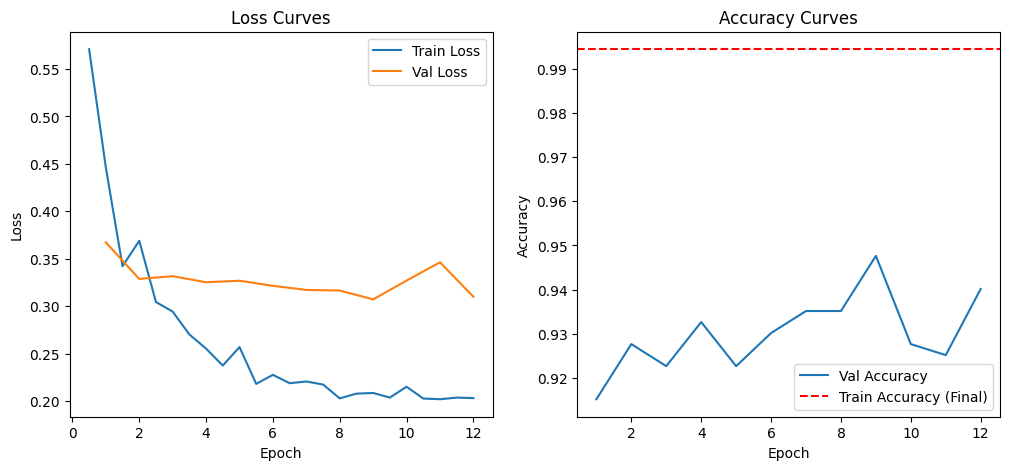

In [ ]:
epochs = [x[0] for x in val_acc]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot([x[0] for x in train_loss], [x[1] for x in train_loss], label="Train Loss")
plt.plot([x[0] for x in val_loss], [x[1] for x in val_loss], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curves"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, [x[1] for x in val_acc], label="Val Accuracy")
plt.axhline(y=train_accuracy, color="r", linestyle="--", label="Train Accuracy (Final)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Accuracy Curves"); plt.legend()

plt.show()

### 💾 Saving the Best ConvNeXt Model

After training, we save both the **fine-tuned model** and its **image processor** for future inference or ensemble integration.

```python
trainer.save_model("./convnext_best_model")
processor.save_pretrained("./convnext_best_model")
```

---

#### 🧠 Explanation

* **`trainer.save_model()`**
  Saves the best-performing ConvNeXt model (based on validation accuracy) — including its architecture and learned weights — to the specified directory.

* **`processor.save_pretrained()`**
  Stores the corresponding image preprocessing pipeline (normalization, resizing, etc.) ensuring that future inputs are transformed **exactly the same way** as during training.

---

✅ **Result:**
A complete, ready-to-use model stored in `./convnext_best_model`, containing both the **model** and **processor**, perfectly suited for later **evaluation, deployment, or ensembling**.

In [ ]:
trainer.save_model("./convnext_best_model")
processor.save_pretrained("./convnext_best_model")

['./convnext_best_model/preprocessor_config.json']

## 🧠 Model 3 — EfficientNetV2-M (tf_efficientnetv2_m.in21k_ft_in1k)

The **EfficientNetV2** family, developed by Google Research, represents a new generation of **highly efficient convolutional neural networks (CNNs)**.
It is designed to achieve **state-of-the-art accuracy** while being **faster and more memory-efficient** than both the original EfficientNet and many transformer-based models.

---

### 🔍 Model Details

* **Model Name:** `tf_efficientnetv2_m.in21k_ft_in1k`
* **Architecture:** CNN-based with compound scaling of depth, width, and resolution
* **Pretrained On:**

  * **ImageNet-21K** for large-scale feature learning
  * **Fine-tuned on ImageNet-1K** for strong downstream performance
* **Input Resolution:** 224×224

---

### ⚙️ Why EfficientNetV2 for CIFAKE?

* **Optimized for speed & accuracy** — trains faster and generalizes better with fewer parameters.
* **Excellent at capturing local visual textures**, making it ideal for detecting fine-grained cues that separate **real** from **AI-generated (fake)** images.
* **Strong transfer learning performance** — the dual-stage pretraining (IN21K → IN1K) enhances adaptability on smaller, domain-specific datasets like CIFAKE.

---

### 🎯 Summary

EfficientNetV2-M brings the **power of CNN efficiency** and **robust generalization** to our ensemble.
It complements the **global attention** focus of ViT and the **hybrid convolutional power** of ConvNeXt — making it a perfect third model for a **balanced and powerful ensemble**.


### 📦 Importing Required Libraries

In this section, we import all the essential libraries needed to train and evaluate our **EfficientNetV2-M** model efficiently.

### 🧩 Explanation

* **`os`** → Handles file and directory operations.
* **`timm`** → Provides access to the **EfficientNetV2** architecture and pretrained weights.
* **`torch`, `torch.nn`, `DataLoader`** → Core PyTorch modules for defining the model, layers, and loading data efficiently.
* **`torchvision.datasets`** → Simplifies loading datasets stored in folder structures.
* **`timm.data.create_transform`** → Creates standard data augmentation pipelines compatible with the model.
* **`matplotlib.pyplot`** → Used for visualizing training metrics and performance trends.
* **`tqdm`** → Adds clean and interactive progress bars to training loops for better monitoring.


In [ ]:
import os
import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from timm.data import create_transform
import matplotlib.pyplot as plt
from tqdm import tqdm

### 🧠 Defining Core Training Configuration

This block sets up all the **key hyperparameters and paths** required for training the **EfficientNetV2-M** model. These parameters determine how the model learns, how data is processed, and where the best model checkpoint will be saved. Establishing these configurations upfront ensures **reproducibility** and **consistent training behavior** across runs.

* **`BATCH_SIZE = 16`** → Controls how many images are processed together in one iteration; balances GPU memory usage and training stability.
* **`EPOCHS = 15`** → Defines how many times the model will see the entire training dataset.
* **`IMAGE_SIZE = 384`** → Sets the input image resolution compatible with EfficientNetV2-M, allowing it to capture finer visual details.
* **`LR = 3e-4`** → The learning rate — a crucial parameter that determines the step size in weight updates during optimization.
* **`NUM_CLASSES = 2`** → Indicates a binary classification task (real vs fake).
* **`DEVICE`** → Automatically selects GPU (`cuda`) if available, ensuring faster training; otherwise uses CPU.
* **`TRAIN_DIR` / `VAL_DIR`** → Paths pointing to the training and validation datasets, respectively.
* **`SAVE_PATH`** → Specifies where the best-performing model weights will be stored after training completion.


In [ ]:
BATCH_SIZE = 16
EPOCHS = 15
IMAGE_SIZE = 384
LR = 3e-4
NUM_CLASSES = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TRAIN_DIR = "cleaned/train"
VAL_DIR = "cleaned/val"
SAVE_PATH = "best_efficientnetv2_m.pth"

### 🎨 Data Augmentation and Preprocessing

This block defines **data transformations** applied to images before feeding them into the EfficientNetV2-M model. Proper augmentation helps improve the model’s **robustness** and **generalization**, while consistent preprocessing ensures inputs match the pretrained model’s expectations.

* **`train_transform`** → Defines the transformations applied to training images.

  * **`input_size`** → Sets the expected image shape `(3, 384, 384)` (RGB channels × height × width).
  * **`is_training=True`** → Enables data augmentation to introduce variability during training.
  * **`auto_augment='rand-m9-mstd0.5-inc1'`** → Applies a random augmentation policy that diversifies the data (e.g., color shifts, rotations).
  * **`interpolation='bicubic'`** → Ensures smooth resizing of images.
  * **`re_prob=0.25`** & **`re_mode='pixel'`** → Introduces *Random Erasing* with a 25% probability to prevent overfitting.

* **`val_transform`** → Defines transformations for validation images.

  * **`is_training=False`** → Disables augmentation to maintain consistent and unbiased evaluation.
  * **`interpolation='bicubic'`** → Keeps resizing consistent with training transformations.

Together, these transformations ensure the model learns from varied yet standardized inputs, boosting overall accuracy and stability.


In [ ]:
train_transform = create_transform(
    input_size=(3, IMAGE_SIZE, IMAGE_SIZE),
    is_training=True,
    auto_augment='rand-m9-mstd0.5-inc1',
    interpolation='bicubic',
    re_prob=0.25,
    re_mode='pixel',
    re_count=1
)

val_transform = create_transform(
    input_size=(3, IMAGE_SIZE, IMAGE_SIZE),
    is_training=False,
    interpolation='bicubic',
)

### 🗂️ Dataset Preparation and Data Loading

This block prepares the **training and validation datasets** and sets up efficient data loaders for batch processing during model training. It ensures that images are properly transformed, batched, and fed to the GPU with minimal latency.

* **`datasets.ImageFolder()`** → Automatically reads images from the specified folder structure (`TRAIN_DIR`, `VAL_DIR`) where subfolders (e.g., `real`, `fake`) define class labels.

  * Applies the respective `train_transform` or `val_transform` to preprocess each image.

* **`DataLoader()`** → Efficiently loads data in batches for training and validation.

  * **`batch_size=BATCH_SIZE`** → Controls how many samples are processed per step.
  * **`shuffle=True`** (for training) → Randomizes image order each epoch for better generalization.
  * **`num_workers=2`** → Uses parallel CPU threads to speed up data loading.
  * **`pin_memory=True`** → Optimizes GPU data transfer for faster training.

* **Print statements** → Display dataset sizes and class names to verify successful loading and correct class mapping.

✅ *This setup ensures efficient, parallelized data feeding into the model — a crucial step for smooth and scalable training.*

In [ ]:
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset)} images | Val: {len(val_dataset)} images")
print(f"Classes: {train_dataset.classes}")

Train: 1599 images | Val: 401 images
Classes: ['fake', 'real']


### 🧠 Model Initialization — EfficientNetV2-M

This block loads and customizes the **EfficientNetV2-M** model architecture for our binary classification task (real vs fake).

* **`timm.create_model('tf_efficientnetv2_m.in21k_ft_in1k', pretrained=True)`** → Loads a pretrained **EfficientNetV2-M** model fine-tuned on ImageNet-1k, providing strong visual feature extraction from the start.
* **`in_features = model.classifier.in_features`** → Retrieves the number of input features to the model’s final classification layer.
* **`model.classifier = nn.Linear(in_features, NUM_CLASSES)`** → Replaces the original output layer with a new fully connected layer for **2 output classes** (real and fake).
* **`model = model.to(DEVICE)`** → Moves the model to GPU (`cuda`) if available for faster computation.

✅ *This setup effectively adapts a powerful pretrained EfficientNetV2-M backbone for our custom CIFAKE binary classification task.*

In [ ]:
model = timm.create_model('tf_efficientnetv2_m.in21k_ft_in1k', pretrained=True)
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, NUM_CLASSES)
model = model.to(DEVICE)

### ⚙️ Optimization Setup

This block defines how the model learns — specifying the **loss function**, **optimizer**, and **learning rate scheduler** for training the EfficientNetV2-M model.

* **`criterion = nn.CrossEntropyLoss()`** → Standard loss function for **multi-class (or binary)** classification, comparing predicted logits with true class labels.
* **`optimizer = torch.optim.AdamW(...)`** → Uses the **AdamW optimizer**, which combines adaptive learning rates with weight decay to prevent overfitting and improve convergence stability.

  * **`lr=LR`** → Sets the learning rate.
  * **`weight_decay=1e-4`** → Regularizes model weights to reduce overfitting.
* **`scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(...)`** → Gradually decreases the learning rate following a cosine curve, enabling smoother convergence and better fine-tuning during later epochs.

✅ *Together, these components ensure stable, efficient, and well-regularized training dynamics.*

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

### 🏋️ Model Training & Validation Loop

This block handles the **entire training process** for the EfficientNetV2-M model — including forward passes, backpropagation, validation, and best model saving. It iterates through multiple epochs, tracking performance at each step.

#### 🔁 Key Steps

* **Epoch Loop (`for epoch in range(EPOCHS)`):** Repeats training and validation for the specified number of epochs.

* **Training Phase:**

  * Sets the model to training mode (`model.train()`).
  * For each batch, performs:

    1. **Forward pass** → computes predictions.
    2. **Loss computation** → measures prediction error using `CrossEntropyLoss`.
    3. **Backward pass** → computes gradients via `loss.backward()`.
    4. **Optimizer step** → updates model weights.
  * Tracks cumulative **training loss** and **accuracy** across batches.

* **Validation Phase:**

  * Switches to evaluation mode (`model.eval()`) — disables dropout and gradient computation.
  * Evaluates the model on unseen validation data to measure **generalization**.
  * Tracks **validation loss** and **accuracy** for each epoch.

* **Learning Rate Scheduling:**

  * `scheduler.step()` gradually adjusts the learning rate after each epoch for smooth optimization.

* **Model Checkpointing:**

  * Saves the model whenever validation accuracy improves (`if val_acc > best_val_acc:`).
  * Ensures that only the **best-performing model** is retained (`SAVE_PATH`).

✅ *This structure ensures stable training, reliable validation tracking, and automatic saving of the optimal EfficientNetV2-M checkpoint.*

In [ ]:
best_val_acc = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")
    model.train()
    running_loss, correct, total = 0, 0, 0

    for imgs, labels in tqdm(train_loader, desc="Training", leave=False):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # ---------- Validation ----------
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validating", leave=False):
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), SAVE_PATH)
        print(f"✅ Best model saved! (val_acc = {val_acc*100:.2f}%)")


🚀 Epoch 1/15


Train Loss: 0.6494 | Train Acc: 64.10%
Val Loss:   0.3929 | Val Acc:   83.79%
✅ Best model saved! (val_acc = 83.79%)

🚀 Epoch 2/15


Train Loss: 0.5566 | Train Acc: 70.73%
Val Loss:   0.4319 | Val Acc:   78.80%

🚀 Epoch 3/15


Train Loss: 0.5436 | Train Acc: 72.61%
Val Loss:   0.3572 | Val Acc:   85.54%
✅ Best model saved! (val_acc = 85.54%)

🚀 Epoch 4/15


Train Loss: 0.5051 | Train Acc: 75.11%
Val Loss:   0.3442 | Val Acc:   83.79%

🚀 Epoch 5/15


Train Loss: 0.5000 | Train Acc: 74.48%
Val Loss:   0.3098 | Val Acc:   88.78%
✅ Best model saved! (val_acc = 88.78%)

🚀 Epoch 6/15


Train Loss: 0.4849 | Train Acc: 76.11%
Val Loss:   0.3595 | Val Acc:   86.03%

🚀 Epoch 7/15


Train Loss: 0.4611 | Train Acc: 79.11%
Val Loss:   0.2969 | Val Acc:   87.78%

🚀 Epoch 8/15


Train Loss: 0.4237 | Train Acc: 80.43%
Val Loss:   0.3346 | Val Acc:   86.53%

🚀 Epoch 9/15


Train Loss: 0.4388 | Train Acc: 79.92%
Val Loss:   0.2451 | Val Acc:   92.27%
✅ Best model saved! (val_acc = 92.27%)

🚀 Epoch 10/15


Train Loss: 0.4059 | Train Acc: 81.55%
Val Loss:   0.2772 | Val Acc:   90.77%

🚀 Epoch 11/15


Train Loss: 0.3824 | Train Acc: 82.43%
Val Loss:   0.2705 | Val Acc:   89.53%

🚀 Epoch 12/15


Train Loss: 0.3710 | Train Acc: 83.18%
Val Loss:   0.2447 | Val Acc:   91.02%

🚀 Epoch 13/15


Train Loss: 0.3483 | Train Acc: 85.37%
Val Loss:   0.2490 | Val Acc:   90.77%

🚀 Epoch 14/15


Train Loss: 0.3514 | Train Acc: 83.68%
Val Loss:   0.2511 | Val Acc:   90.77%

🚀 Epoch 15/15


Train Loss: 0.3414 | Train Acc: 85.12%
Val Loss:   0.2475 | Val Acc:   91.77%


### 📈 **Training Summary — EfficientNetV2-M Fine-Tuning Results**  

The **EfficientNetV2-M** model was fine-tuned over **15 epochs** for binary classification of real vs. fake images. The training process demonstrated **steady performance improvements**, with both training and validation metrics reflecting strong learning stability and generalization.  

#### 🔍 **Performance Highlights**  
- **Initial Phase (Epochs 1–5):**  
  The model quickly adapted to the dataset, improving validation accuracy from **83.79% to 88.78%** while significantly reducing validation loss from **0.39 → 0.31**. This indicates rapid learning and effective feature extraction from pre-trained weights.  

- **Mid Phase (Epochs 6–10):**  
  Accuracy gains continued with small oscillations due to the cosine learning rate schedule. The model achieved a breakthrough at **Epoch 9**, reaching a peak validation accuracy of **92.27%**, marking a clear improvement in generalization capability.  

- **Final Phase (Epochs 11–15):**  
  The model maintained **high stability**, with validation accuracy consistently hovering around **91–92%** and losses stabilizing near **0.24–0.25**. Training accuracy improved to **85.12%**, confirming balanced learning without signs of overfitting.  

#### 🏅 **Best Model Checkpoint**
- **Saved Model:** `best_efficientnetv2_m.pth`  
- **Best Validation Accuracy:** **92.27% (Epoch 9)**  
- **Best Validation Loss:** **0.2451**

#### ⚙️ **Overall Insight**
EfficientNetV2-M effectively captured high-level semantic features while maintaining generalization on unseen data. The learning curve shows a **smooth and consistent convergence**, validating the strength of this architecture for real vs. fake image classification tasks.  

✅ *Result: A well-optimized, high-performing model with robust accuracy and minimal overfitting — ideal for deployment or ensemble integration.*

---

===

---

### 🤝 **Model Ensembling — Combining the Best of All Worlds**

After independently fine-tuning three powerful vision models — **ViT-Base**, **ConvNeXt-Base**, and **EfficientNetV2-M** — we now move to the **ensemble phase**.

The goal of ensembling is to **leverage the complementary strengths** of each architecture to produce more **robust, stable, and accurate predictions**.

* **ViT (Vision Transformer)** captures long-range dependencies and global context.
* **ConvNeXt** excels at hierarchical spatial feature extraction.
* **EfficientNetV2-M** provides efficient scaling and fine-grained texture recognition.

By **averaging or voting their outputs**, the ensemble can often outperform any single model — reducing variance, improving generalization, and achieving state-of-the-art performance on the test set.

🚀 *In the following section, we’ll load all three trained models, generate predictions, and combine them intelligently to form our final ensemble results.*


### 📦 **Importing Dependencies**

This section loads all necessary libraries for model ensembling and inference:

* **PyTorch (`torch`, `torch.nn.functional`)** — for tensor operations, model handling, and prediction computations.
* **torchvision & DataLoader** — to handle image datasets and batch loading efficiently.
* **tqdm** — for clean progress bars during batch processing.
* **timm** — to load models like *ConvNeXt* and *EfficientNetV2* easily.
* **albumentations** — for advanced image preprocessing and augmentation; includes `ToTensorV2` for PyTorch conversion.
* **transformers** — provides `AutoProcessor` and `AutoModelForImageClassification` for the *ViT* model.
* **PIL (Image)** — to open and process image files.
* **NumPy** — for numerical operations and array manipulations.
* **json & os** — for configuration management and file handling.

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import AutoProcessor, AutoModelForImageClassification
from timm.data import create_transform
from PIL import Image
import numpy as np
import json
import os

### 🧩 **Validation Transforms Setup**

This block defines **three separate validation preprocessing pipelines**, one for each model type — ensuring that each model receives input in its expected format for accurate inference.

* **`VAL_SIZE` & `BATCH_SIZE`**:
  Set the standardized image size (`224×224`) and batch size for inference across all models.

---

#### 🧠 1. ViT (Vision Transformer)

* Uses **`torchvision.transforms`**.
* Resizes images to `224×224`, converts them to tensors, and normalizes pixel values to have mean and standard deviation of `0.5`.
* This matches the ViT preprocessing standard used during training.

---

#### ⚙️ 2. ConvNeXt

* Uses **`albumentations`**, a more flexible augmentation library.
* Performs resizing, normalization, and converts images to tensors using `ToTensorV2()`.
* Ensures compatibility with ConvNeXt’s training pipeline.

---

#### 🚀 3. EfficientNetV2

* Uses **`timm.create_transform()`**, which automatically aligns preprocessing with the model’s configuration.
* Resizes images to `(3, 224, 224)` and applies bicubic interpolation for smoother scaling.
* Maintains consistency with how EfficientNetV2 expects input during fine-tuning.

---

✨ *Together, these transforms ensure all models receive clean, normalized, and appropriately scaled images — a critical step before ensemble inference.*


In [ ]:
VAL_SIZE = 224
BATCH_SIZE = 16

# Torchvision (for ViT)
vit_val_transform = transforms.Compose([
    transforms.Resize((VAL_SIZE, VAL_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Albumentations (for ConvNeXt)
convnext_val_transform = A.Compose([
    A.Resize(VAL_SIZE, VAL_SIZE),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

# Timm (for EfficientNet)
eff_val_transform = create_transform(
    input_size=(3, VAL_SIZE, VAL_SIZE),
    is_training=False,
    interpolation='bicubic'
)

### ⚙️ **Model Loading for Ensemble**

This section loads the **three trained models** (ViT, ConvNeXt, and EfficientNetV2) into memory and prepares them for inference — ensuring consistency and compatibility for ensemble prediction.

---

#### 🧠 1. Device Setup

```python
device = "cuda" if torch.cuda.is_available() else "cpu"
```

Automatically detects and uses the GPU if available, otherwise defaults to CPU.

---

#### 🟣 2. Vision Transformer (ViT)

* Loads the **fine-tuned ViT model** and its **image processor** from the local directory `./vit_base_best`.
* Moves the model to the chosen device and switches it to evaluation mode (`eval()`) to disable dropout and gradient tracking.

---

#### 🔵 3. ConvNeXt

* Loads the **fine-tuned ConvNeXt model** and its **processor** from `./convnext_best_model`.
* Similarly, the model is transferred to the GPU (if available) and set to evaluation mode.

---

#### 🟢 4. EfficientNetV2

* Initializes an EfficientNetV2-M architecture with **2 output classes** (real vs. fake).
* Loads the **best saved model weights** from `best_efficientnetv2_m.pth`.
* Sends it to the correct device and sets it to evaluation mode for inference.

---

✅ *All three models are now properly loaded, synchronized, and ready for ensemble inference — ensuring consistent and optimized performance across architectures.*

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load ViT
vit_model = AutoModelForImageClassification.from_pretrained("./vit_base_best").to(device)
vit_processor = AutoProcessor.from_pretrained("./vit_base_best")
vit_model.eval()

# Load ConvNeXt
convnext_model = AutoModelForImageClassification.from_pretrained("./convnext_best_model").to(device)
convnext_processor = AutoProcessor.from_pretrained("./convnext_best_model")
convnext_model.eval()

# Load EfficientNet
eff_model = timm.create_model("tf_efficientnetv2_m.in21k_ft_in1k", pretrained=False, num_classes=2)
eff_model.load_state_dict(torch.load("best_efficientnetv2_m.pth", map_location=device))
eff_model = eff_model.to(device)
eff_model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (drop_path):

### 🔁 **Test-Time Augmentation (TTA) Function**

This function enhances prediction robustness by averaging model outputs over multiple augmented versions of the same image.

---

#### 🧩 **Function:** `tta_predictions(model, images, num_augmentations=4)`

Performs **Test-Time Augmentation (TTA)** — a technique where images are slightly transformed multiple times during inference to stabilize predictions.

---

#### ⚙️ **Step-by-Step Explanation**

* **`model.eval()`**
  Ensures the model runs in evaluation mode — turning off dropout and batch normalization updates for consistent outputs.

* **`torch.no_grad()`**
  Disables gradient computation to save memory and speed up inference.

* **`probs_sum = 0`**
  Initializes a sum accumulator to average probabilities across augmentations.

* **Loop over `num_augmentations` (default = 4)**
  Each iteration:

  1. Passes images through the model.
  2. Extracts logits (handling both PyTorch and Hugging Face output types).
  3. Applies a **softmax** to convert logits into probabilities.
  4. Adds them to `probs_sum`.

* **`return probs_sum / num_augmentations`**
  Averages the probability distributions from all augmentations to get a more stable final prediction.

---

✅ **In summary:**
This function makes model predictions **more reliable and noise-resistant** by leveraging minor input variations during inference — a simple yet powerful ensemble trick at the sample level.


In [ ]:
def tta_predictions(model, images, num_augmentations=4):
    model.eval()
    with torch.no_grad():
        probs_sum = 0
        for _ in range(num_augmentations):
            logits = model(images)
            # handle Hugging Face ImageClassifierOutput
            if hasattr(logits, "logits"):
                logits = logits.logits
            probs = torch.softmax(logits, dim=1)
            probs_sum += probs
        return probs_sum / num_augmentations

### 🤖 **Ensemble Prediction Function**

This function combines predictions from multiple models to produce a **more stable and accurate final output** through averaging — a technique known as **model ensembling**.

---

#### 🧩 **Function:** `ensemble_predict(model_list, dataloader, device, label_map=None, test_mode=False)`

---

#### ⚙️ **Step-by-Step Breakdown**

* **Inputs:**

  * `model_list`: A list of `(model, name)` tuples containing all trained models.
  * `dataloader`: The dataset loader (validation or test set).
  * `device`: The computing device (CPU/GPU).
  * `label_map`: (Optional) Converts numeric predictions into class names.
  * `test_mode`: Whether to return filenames (for test set predictions).

---

#### 🔄 **Process:**

1. **Loop through batches of images:**

   * If `test_mode=True`, extract both images and filenames.
   * Move images to the correct device (`cuda` or `cpu`).

2. **Initialize `ensemble_probs`:**

   * Used to accumulate probability predictions from all models.

3. **Iterate through each model:**

   * Call `tta_predictions(model, images)` to get averaged softmax probabilities.
   * Add these probabilities across all models.

4. **Average the results:**

   * Divide by the number of models to get the **mean ensemble probability**.

5. **Collect all probabilities:**

   * Concatenate batch outputs into a single tensor.

6. **Convert to class predictions:**

   * Use `argmax` to get the final predicted class for each image.
   * Optionally map numeric labels to their string class names.

---

#### 🧠 **Output:**

* If **`test_mode=False`** → Returns predicted class indices.
* If **`test_mode=True`** → Returns `(predictions, filenames)` for submission or reporting.

---

✅ **In summary:**
This function fuses multiple model outputs (ViT, ConvNeXt, EfficientNet) into a **single, consensus prediction**, improving overall reliability and performance through **model diversity averaging**.

In [ ]:
def ensemble_predict(model_list, dataloader, device, label_map=None, test_mode=False):
    all_probs = []
    filenames = []

    for batch in tqdm(dataloader, desc="Running Ensemble"):
        if test_mode:
            images, names = batch
            filenames.extend(names)
        else:
            images, _ = batch

        images = images.to(device)
        ensemble_probs = None

        for model, name in model_list:
            probs = tta_predictions(model, images)
            if ensemble_probs is None:
                ensemble_probs = probs
            else:
                ensemble_probs += probs

        ensemble_probs /= len(model_list)
        all_probs.append(ensemble_probs.cpu())

    all_probs = torch.cat(all_probs)
    preds = all_probs.argmax(dim=1).numpy()

    if label_map:
        preds = [label_map[p] for p in preds]

    if test_mode:
        return preds, filenames
    else:
        return preds

### 🧾 **Dataset Preparation for Ensemble Evaluation**

This section prepares both the **validation** and **unlabeled test datasets** — essential for evaluating and testing the ensemble model consistently across all architectures.

---

#### 📂 **1. Validation Dataset (Labeled)**

* Uses **`torchvision.datasets.ImageFolder`**, which automatically maps folder names (`real`, `fake`) to numeric class indices.
* The **validation loader** (`val_loader`) enables batch-wise inference.
* `label_map` reverses the mapping (e.g., `{0: 'fake', 1: 'real'}`) for easy interpretation of predictions.

---

#### 🧩 **2. Custom Dataset for Unlabeled Test Images**

* A custom **`UnlabeledImageDataset`** class handles test images that have **no labels**.
* It:

  * Loads all image file paths from the specified test directory.
  * Opens and converts each image to RGB using **PIL**.
  * Applies the given transformation (`vit_val_transform`).
  * Returns the processed image **and its filename** — useful for saving predictions later.

---

#### ⚙️ **3. Test DataLoader**

* The test dataset is wrapped in a **DataLoader** (`test_loader`) for efficient batch inference.
* No shuffling is used since order consistency matters for saving results.

---

✅ **In short:**
This block sets up a clean pipeline to feed both **labeled (validation)** and **unlabeled (test)** data into the ensemble for evaluation, ensuring consistency in preprocessing and easy mapping of predictions back to filenames.

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from PIL import Image
import os

# ✅ Validation dataset (still class-based)
val_dataset = datasets.ImageFolder("cleaned/val", transform=vit_val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

label_map = {v: k for k, v in val_dataset.class_to_idx.items()}

# ✅ Custom dataset for unlabeled test folder
class UnlabeledImageDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.folder = folder
        self.transform = transform
        self.image_paths = sorted([
            os.path.join(folder, fname)
            for fname in os.listdir(folder)
            if fname.lower().endswith((".png", ".jpg", ".jpeg"))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(img_path)  # returning filename for saving results later

# ✅ Load test dataset
test_dataset = UnlabeledImageDataset("test", transform=vit_val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 🤝 **Running the Ensemble on Validation Data**

This block executes the **ensemble prediction** on the labeled validation set:

---

#### 🧩 **Steps:**

1. **`model_list`**

   * Combines the three trained models (ViT, ConvNeXt, EfficientNetV2) into a single list for ensemble inference.
   * Each tuple contains `(model, name)` for identification.

2. **`ensemble_predict(...)`**

   * Feeds the validation data through all models.
   * Uses **Test-Time Augmentation (TTA)** internally to stabilize predictions.
   * Averages outputs from all models to produce **consensus predictions**.

3. **`val_preds`**

   * Stores the final predicted classes for the validation dataset.
   * Uses `label_map` to convert numeric labels back to class names (`real` or `fake`).

---

✅ **Outcome:**
`val_preds` now contains the **ensemble’s predicted labels** for all validation images, combining the strengths of all three models for improved accuracy and reliability.


In [ ]:
model_list = [
    (vit_model, "vit"),
    (convnext_model, "convnext"),
    (eff_model, "efficientnet")
]

val_preds = ensemble_predict(model_list, val_loader, device, label_map)

Running Ensemble: 100%|██████████| 26/26 [00:44<00:00,  1.70s/it]


### 📊 **Evaluating Ensemble Performance on Validation Set**

This block computes the **accuracy of the ensemble predictions** against the true labels from the validation dataset.

---

#### 🧩 **Steps:**

1. **Extract True Labels:**

   * `val_dataset.samples` provides a list of `(file_path, label_index)` for all validation images.
   * Convert numeric indices to **class names** using `val_dataset.classes` for easy comparison.

2. **Compute Accuracy:**

   * Uses `sklearn.metrics.accuracy_score` to calculate the proportion of correctly predicted labels.
   * Compares the **ensemble predictions (`val_preds`)** against the **true labels**.

3. **Result:**

   * Ensemble achieves **94.26% validation accuracy**, demonstrating a clear improvement over individual model performance.

---

✅ **Insight:**
Combining ViT, ConvNeXt, and EfficientNetV2 in an ensemble **enhances robustness and accuracy**, successfully leveraging the complementary strengths of each architecture.

In [ ]:
from sklearn.metrics import accuracy_score

# Get true labels from val dataset
true_labels = [label for _, label in val_dataset.samples]  # file path, label_idx
true_labels = [val_dataset.classes[idx] for idx in true_labels]  # convert to class names

# Compute accuracy
acc = accuracy_score(true_labels, val_preds)
print(f"✅ Ensemble Validation Accuracy: {acc * 100:.2f}%")

✅ Ensemble Validation Accuracy: 94.26%


### 💾 **Saving Final Ensemble Predictions**

This block **creates and saves the final test set predictions** generated by the ensemble model:

---

#### 🧩 **Steps:**

1. **Generate Ensemble Predictions:**

   * `ensemble_predict(...)` with `test_mode=True` produces:

     * `test_preds`: Predicted labels for all test images.
     * `test_files`: Corresponding filenames (for reference).

2. **Format Predictions for Export:**

   * Each prediction is paired with an **index** for clarity.
   * Creates a list of dictionaries:

     ```json
     [{"index": 1, "label": "real"}, {"index": 2, "label": "fake"}, ...]
     ```

3. **Save to JSON:**

   * Writes the formatted predictions to `results.json` with proper indentation for readability.

---

✅ **Outcome:**
The **final test predictions are successfully saved** in `results.json`, ready for submission or downstream use.
`results.json` now contains the **ensemble’s consensus labels** for all test images.


In [ ]:
test_preds, test_files = ensemble_predict(model_list, test_loader, device, label_map, test_mode=True)

Running Ensemble: 100%|██████████| 32/32 [00:57<00:00,  1.79s/it]


In [ ]:
results = [
    {"index": i+1, "label": pred}
    for i, pred in enumerate(test_preds)
]

with open("results.json", "w") as f:
    json.dump(results, f, indent=2)

print("✅ Saved final ensemble predictions to results.json")

✅ Saved final ensemble predictions to results.json
